# DataLoad

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from keras.models import load_model

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
    
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다.
                    Resize(
                        width=224,
                        height=224
                        )
                    ])

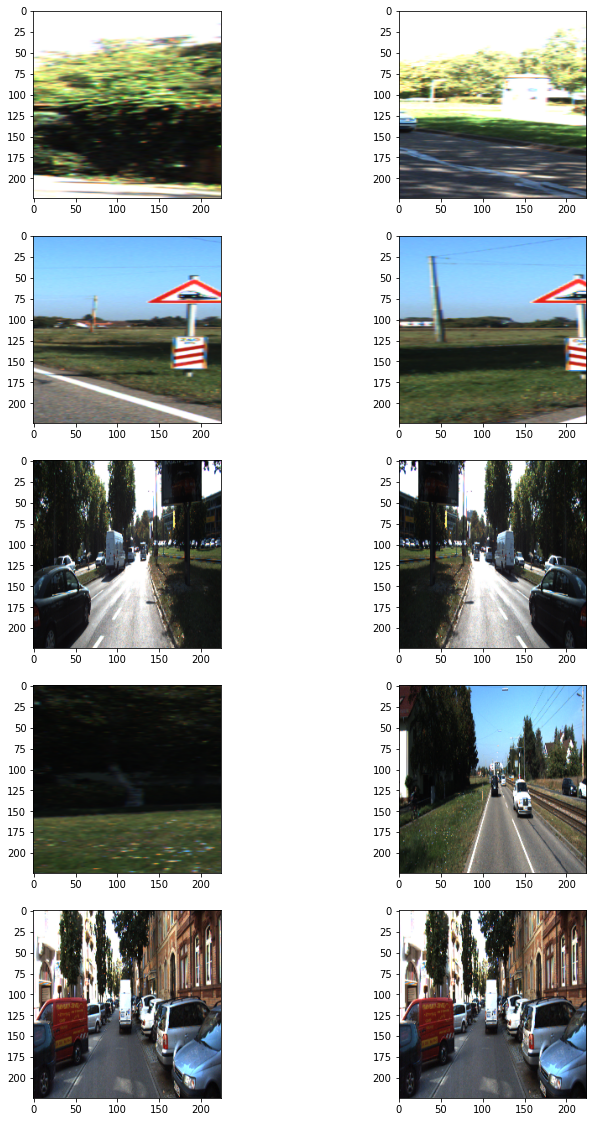

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# U-Net 모델

In [6]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [7]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
11/11 [==============================] - 75s 1s/step - loss: 0.6880 - val_loss: 0.6741
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.6315 - val_loss: 0.0802
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.0342 - val_loss: 0.0352
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.0299 - val_loss: 0.0372
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.0290 - val_loss: 0.0363
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0304 - val_loss: 0.0296
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0234 - val_loss: 0.0275
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.0350 - val_loss: 0.0274
Epoch 9/100
11/11 [==============================] - 13s 1s/step - loss: 0.0243 - val_loss: 0.0255
Epoch 10/100
11/11 [==============================] - 13s 1s/step - loss: 0.0224 - val_loss: 0.0285
Epoch 11/

In [8]:
model = tf.keras.models.load_model(model_path)

# U-Net++ 모델
+ 배치사이즈  16 -> 4

In [9]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]

    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [10]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

In [11]:
def conv2Dblock(input_img,channel,kernel_size = 3):
    x = Conv2D(channel,kernel_size, activation='relu',padding='same',kernel_initializer='he_normal')(input_img)
    x = Conv2D(channel,kernel_size, activation='relu',padding='same',kernel_initializer='he_normal')(x)
    
    return x;

In [12]:
def U_plusplus_build_model(input_shape=(224, 224, 3)):
    channel = [64,128,256,512,1024];
    
    inputs = Input(input_shape)

    #Contracting Path

    #Backbone X0,0
    conv1_1 = conv2Dblock(inputs,64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
    
    #Backbone X1,0
    conv2_1 = conv2Dblock(pool1,128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    
    #Backbone X2,0
    conv3_1 = conv2Dblock(pool2,256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)
    
    #Backbone X3,0
    conv4_1 = conv2Dblock(pool3,512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    
    #Backbone X4,0
    conv5_1 = conv2Dblock(pool4,1024)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5_1)  
    
    #X0,1
    #Upsmapling
    up1= Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
    #Skip connection
    merge1 = concatenate([up1,conv1_1], axis = 3)
    conv1_2 = conv2Dblock(merge1,64)
    
    #X1,1
    #Upsmapling
    up2_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_1)
    #Skip connection
    merge2 = concatenate([up2_1,conv2_1], axis = 3)
    conv2_2 = conv2Dblock(merge2,128)
    
    #X0,2
    #Upsmapling
    up2_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_2)
    #Skip connection
    merge3 = concatenate([up2_2,conv1_1,conv1_2], axis = 3)
    conv1_3 = conv2Dblock(merge3,64)
    
    #X2,1
    #Upsampling
    up3_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_1)
    #Skip connection
    merge4 = concatenate([up3_1,conv3_1], axis = 3)
    conv3_2 = conv2Dblock(merge4,256)
    
    #X1,2
    #Upsampling
    up3_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_2)
    #Skip connection
    merge5 = concatenate([up3_2,conv2_1,conv2_2], axis = 3)
    conv2_3 = conv2Dblock(merge5,128)
    
    #X0,3
    #Upsampling
    up3_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_3)
    #Skip connection
    merge6 = concatenate([up3_3,conv1_1,conv1_2,conv1_3], axis = 3)
    conv1_4 = conv2Dblock(merge6,64)
    
    #X3,1
    #Upsampling
    up4_1 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv5_1)
    #Skip connection
    merge7 = concatenate([up4_1,conv4_1], axis = 3)
    conv4_2 = conv2Dblock(merge7,512)
    
    #X2,2
    #Upsampling
    up4_2 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_2)
    #Skip connection
    merge8 = concatenate([up4_2,conv3_1,conv3_2], axis = 3)
    conv3_3 = conv2Dblock(merge8,256)
    
    #X1,3
    #Upsampling
    up4_3 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_3)
    #Skip connection
    merge9 = concatenate([up4_3,conv2_1,conv2_2,conv2_3], axis = 3)
    conv2_4 = conv2Dblock(merge9,128)
    
    #X0,4
    #Upsampling
    up4_4 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_4)
    #Skip connection
    merge10 = concatenate([up4_4,conv1_1,conv1_2,conv1_3,conv1_4], axis = 3)
    conv1_5 = conv2Dblock(merge10,64)
    
    
    # output
    output = Conv2D(1, (1,1), activation='sigmoid', kernel_initializer = 'he_normal', padding='same')(conv1_5)
    model = Model(inputs=inputs, outputs = output)
    return model

In [13]:
model = U_plusplus_build_model(input_shape=(224,224,3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

In [14]:
model_U_plus_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

model_U_plus = U_plusplus_build_model()
model_U_plus.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model_U_plus.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_U_plus.save(model_U_plus_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 137s 2s/step - loss: 0.6115 - val_loss: 0.1213
Epoch 2/100
43/43 [==============================] - 68s 2s/step - loss: 0.1376 - val_loss: 0.1371
Epoch 3/100
43/43 [==============================] - 68s 2s/step - loss: 0.1238 - val_loss: 0.1068
Epoch 4/100
43/43 [==============================] - 68s 2s/step - loss: 0.1154 - val_loss: 0.1077
Epoch 5/100
43/43 [==============================] - 67s 2s/step - loss: 0.1026 - val_loss: 0.1123
Epoch 6/100
43/43 [==============================] - 67s 2s/step - loss: 0.0886 - val_loss: 0.1006
Epoch 7/100
43/43 [==============================] - 67s 2s/step - loss: 0.0887 - val_loss: 0.1053
Epoch 8/100
43/43 [==============================] - 68s 2s/step - loss: 0.0907 - val_loss: 0.0844
Epoch 9/100
43/43 [==============================] - 68s 2s/step - loss: 0.0853 - val_loss: 0.0711
Epoch 10/100
43/43 [==============================] - 67s 2s/step - loss: 0.0569 - val_loss: 0.0662
Epoch 11

In [15]:
model_U_plus = tf.keras.models.load_model(model_U_plus_path)

# 시각화 및 IoU 결과

In [6]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [7]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #도로인식 결과범위
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [8]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'
model = load_model(model_path)

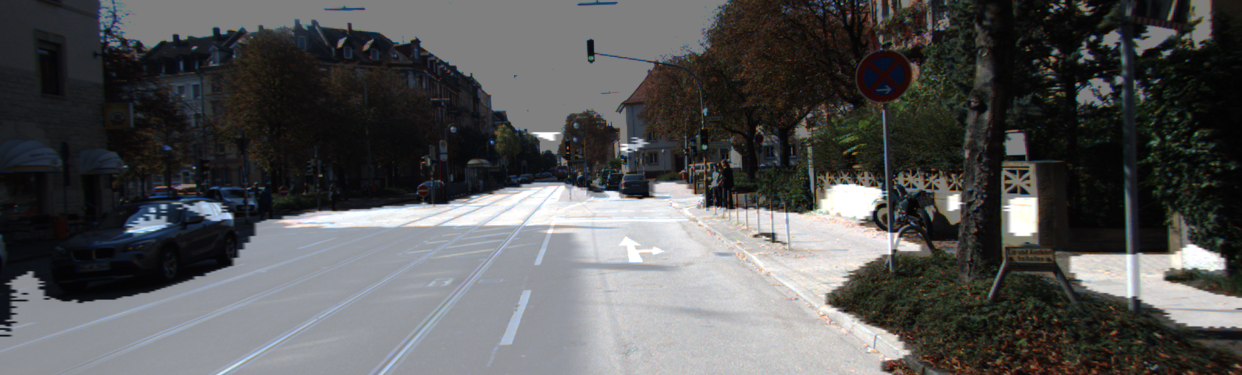

In [9]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
output

In [10]:
calculate_iou_score(target, prediction)

IoU : 0.781801


0.7818007662835249

In [11]:
model_U_plus_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'
model_U_plus = load_model(model_U_plus_path)

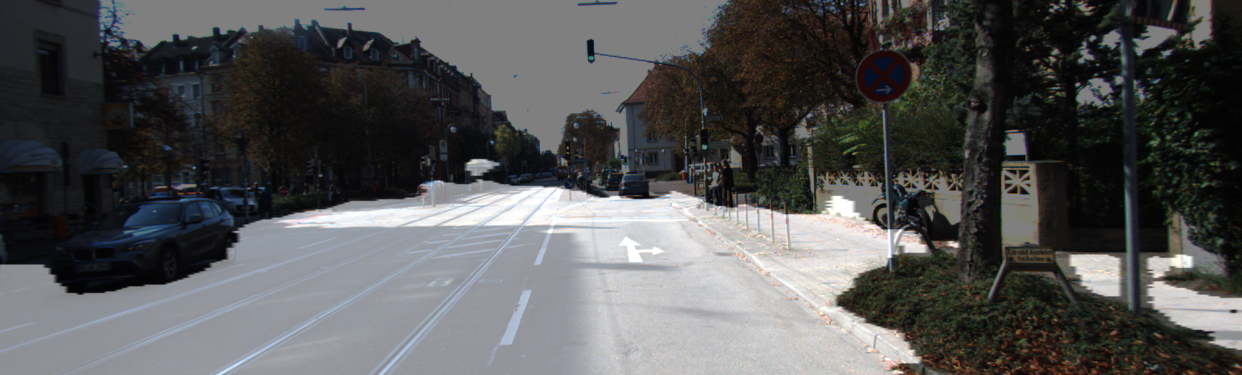

In [12]:
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_U_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )
output

In [13]:
calculate_iou_score(target, prediction)

IoU : 0.807682


0.8076823923691673

---
U++net을 구현할때 처음에 이해가 잘 되지 않아서 쉽지 않았는데   
Resnet과 비슷한 원리의 구현이라 Plain net과 Resnet을 떠올리며   
skip connection구현을 시작하니 잘 구현한것같다.
결과를 보면 IoU값이 U-Net 보다 U-Net++ 이 더 높게 나왔고 결과 사진을 보더라도 의미없는 하늘, 차량 등 U-Net++이 더 잘 구분하고 있다.